In [63]:
# Imports nécessaires
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
import os
import re
import string
import random
from collections import Counter, defaultdict
from datetime import datetime

import requests
import json

# Pour l'export ONNX
import onnx
import onnxruntime as ort

# Configuration des devices
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device utilisé: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Mémoire GPU disponible: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")

print("Configuration terminée !")

Device utilisé: cuda
GPU: NVIDIA GeForce RTX 3060 Laptop GPU
Mémoire GPU disponible: 6.0 GB
Configuration terminée !


In [64]:
# Fonction pour charger le corpus de poèmes anglais
def load_poetry_corpus():
    """
    Charge un corpus de poèmes anglais.
    Essaie plusieurs sources : Hugging Face via pandas, puis alternatives.
    """
    
    # Option 1 : Essayer le dataset merve/poetry avec pandas
    try:
        print("Tentative de chargement du dataset merve/poetry avec pandas...")
        df = pd.read_csv("hf://datasets/merve/poetry/poetry.csv")
        
        print(f"Dataset chargé: {len(df)} poèmes")
        print(f"Colonnes disponibles: {list(df.columns)}")
        
        # Explorer les premières lignes pour comprendre la structure
        print("\nAperçu des données:")
        print(df.head())
        
        # Identifier la colonne contenant le texte du poème
        text_column = None
        for col in ['content', 'poem', 'text', 'verse', 'lines']:
            if col in df.columns:
                text_column = col
                break
        
        if text_column is None:
            # Si aucune colonne évidente, prendre la première colonne de texte
            for col in df.columns:
                if df[col].dtype == 'object':  # Colonnes de texte
                    text_column = col
                    break
        
        if text_column:
            print(f"Utilisation de la colonne '{text_column}' pour les poèmes")
            
            # Filtrer et nettoyer les poèmes
            poems = []
            for _, row in df.iterrows():
                poem_text = str(row[text_column])
                
                # Filtrer les poèmes valides (longueur raisonnable)
                if 50 <= len(poem_text) <= 2000 and poem_text.strip():
                    # Nettoyer le texte
                    cleaned_poem = poem_text.strip()
                    # Enlever les caractères de contrôle indésirables
                    cleaned_poem = re.sub(r'[\x00-\x08\x0b\x0c\x0e-\x1f\x7f-\x84\x86-\x9f]', '', cleaned_poem)
                    
                    if len(cleaned_poem) >= 50:
                        poems.append(cleaned_poem)
                
                # Limiter à 2000 poèmes pour l'entraînement
                if len(poems) >= 2000:
                    break
            
            if poems:
                print(f"Poèmes sélectionnés: {len(poems)}")
                corpus = '\n\n'.join(poems)
                print(f"Corpus final: {len(corpus)} caractères")
                return corpus
        
        print("Impossible d'identifier la colonne de texte dans le dataset")
        
    except Exception as e:
        print(f"Erreur avec pandas/Hugging Face: {e}")
    
    # Option 2 : Corpus de base (poèmes anglais classiques)
    print("Utilisation d'un corpus de base en anglais...")
    
    # Poèmes anglais classiques (domaine public)
    base_poems = [
        """Two roads diverged in a yellow wood,
And sorry I could not travel both
And be one traveler, long I stood
And looked down one as far as I could
To where it bent in the undergrowth;

Then took the other, as just as fair,
And having perhaps the better claim,
Because it was grassy and wanted wear;
Though as for that the passing there
Had worn them really about the same,""",

        """I wandered lonely as a cloud
That floats on high o'er vales and hills,
When all at once I saw a crowd,
A host, of golden daffodils;
Beside the lake, beneath the trees,
Fluttering and dancing in the breeze.

Continuous as the stars that shine
And twinkle on the milky way,
They stretched in never-ending line
Along the margin of a bay:""",

        """Shall I compare thee to a summer's day?
Thou art more lovely and more temperate:
Rough winds do shake the darling buds of May,
And summer's lease hath all too short a date:
Sometime too hot the eye of heaven shines,
And often is his gold complexion dimm'd;
And every fair from fair sometime declines,
By chance or nature's changing course untrimm'd;""",

        """Because I could not stop for Death,
He kindly stopped for me;
The carriage held but just ourselves
And Immortality.

We slowly drove, he knew no haste,
And I had put away
My labor, and my leisure too,
For his civility.

We passed the school where children played,
Their lessons scarcely done;""",

        """Do not go gentle into that good night,
Old age should burn and rave at close of day;
Rage, rage against the dying of the light.

Though wise men at their end know dark is right,
Because their words had forked no lightning they
Do not go gentle into that good night.

Good men, the last wave by, crying how bright
Their frail deeds might have danced in a green bay,""",

        """The woods are lovely, dark and deep,
But I have promises to keep,
And miles to go before I sleep,
And miles to go before I sleep.

Whose woods these are I think I know.
His house is in the village though;
He will not see me stopping here
To watch his woods fill up with snow.""",

        """Hope is the thing with feathers
That perches in the soul,
And sings the tune without the words,
And never stops at all,

And sweetest in the gale is heard;
And sore must be the storm
That could abash the little bird
That kept so many warm.

I've heard it in the chilliest land,
And on the strangest sea;""",

        """How do I love thee? Let me count the ways.
I love thee to the depth and breadth and height
My soul can reach, when feeling out of sight
For the ends of being and ideal grace.
I love thee to the level of every day's
Most quiet need, by sun and candle-light.

I love thee freely, as men strive for right.
I love thee purely, as they turn from praise.
I love thee with the passion put to use
In my old griefs, and with my childhood's faith.""",

        """Once upon a midnight dreary, while I pondered, weak and weary,
Over many a quaint and curious volume of forgotten lore—
While I nodded, nearly napping, suddenly there came a tapping,
As of some one gently rapping, rapping at my chamber door.
"'Tis some visitor," I muttered, "tapping at my chamber door—
Only this and nothing more."

Ah, distinctly I remember it was in the bleak December;
And each separate dying ember wrought its ghost upon the floor.""",

        """The sea whispers secrets to the shore,
While waves dance in eternal rhythm.
Seagulls cry above the foam,
And clouds drift across the sky.
The horizon calls to wandering souls,
Who seek adventure beyond the blue.

Salt spray kisses weathered faces,
As ships sail toward distant lands.
The ocean holds a thousand stories,
Of sailors brave and true.""",

        """In gardens where the roses bloom,
And butterflies dance in the light,
The morning dew glistens bright,
On petals soft as silk.
Bees hum their ancient songs,
While flowers nod in gentle breeze.

The sun climbs high above the trees,
Painting shadows on the ground.
Nature's symphony surrounds
All who stop to listen close."""
    ]
    
    # Ajouter des variations et extensions
    extended_poems = []
    for poem in base_poems:
        extended_poems.append(poem)
        
        # Créer des variations légères
        lines = poem.split('\n')
        if len(lines) > 6:
            # Réorganiser quelques strophes
            mid_point = len(lines) // 2
            varied_poem = '\n'.join(lines[mid_point:] + lines[:mid_point])
            extended_poems.append(varied_poem)
    
    # Répéter pour avoir plus de données d'entraînement
    final_corpus = '\n\n'.join(extended_poems * 4)
    print(f"Corpus de base créé: {len(final_corpus)} caractères")
    return final_corpus

# Charger le corpus
print("Chargement du corpus de poèmes anglais...")
corpus = load_poetry_corpus()
print(f"Corpus chargé: {len(corpus)} caractères")
print(f"Extrait:\n{corpus[:400]}...")

Chargement du corpus de poèmes anglais...
Tentative de chargement du dataset merve/poetry avec pandas...
Dataset chargé: 573 poèmes
Colonnes disponibles: ['author', 'content', 'poem name', 'age', 'type']

Aperçu des données:
                                    author  \
0                      WILLIAM SHAKESPEARE   
1  DUCHESS OF NEWCASTLE MARGARET CAVENDISH   
2                           THOMAS BASTARD   
3                           EDMUND SPENSER   
4                        RICHARD BARNFIELD   

                                             content  \
0  Let the bird of loudest lay\r\nOn the sole Ara...   
1  Sir Charles into my chamber coming in,\r\nWhen...   
2  Our vice runs beyond all that old men saw,\r\n...   
3  Lo I the man, whose Muse whilome did maske,\r\...   
4  Long have I longd to see my love againe,\r\nSt...   

                                 poem name          age                  type  
0               The Phoenix and the Turtle  Renaissance  Mythology & Folklore  
1

In [65]:
# Classes pour l'encodage char-level
class CharLevelEncoder:
    """Encodeur/décodeur pour l'approche char-level"""
    
    def __init__(self, text):
        self.chars = sorted(list(set(text)))
        self.vocab_size = len(self.chars)
        self.char_to_idx = {ch: i for i, ch in enumerate(self.chars)}
        self.idx_to_char = {i: ch for i, ch in enumerate(self.chars)}
        
        print(f"Vocabulaire char-level créé:")
        print(f"- Taille: {self.vocab_size} caractères")
        print(f"- Caractères: {self.chars}")
    
    def encode(self, text):
        """Convertit le texte en séquence d'indices"""
        return [self.char_to_idx[ch] for ch in text if ch in self.char_to_idx]
    
    def decode(self, indices):
        """Convertit une séquence d'indices en texte"""
        return ''.join([self.idx_to_char[idx] for idx in indices])
    
    def one_hot_encode(self, indices):
        """Convertit les indices en encodage one-hot"""
        one_hot = torch.zeros(len(indices), self.vocab_size)
        for i, idx in enumerate(indices):
            one_hot[i, idx] = 1
        return one_hot

# Dataset pour l'entraînement char-level
class CharLevelDataset(Dataset):
    """Dataset pour l'approche char-level"""
    
    def __init__(self, text, encoder, seq_length=50):
        self.encoder = encoder
        self.seq_length = seq_length
        
        # Encoder tout le texte
        self.encoded_text = encoder.encode(text)
        self.data_size = len(self.encoded_text)
        
        print(f"Dataset char-level créé:")
        print(f"- Longueur de séquence: {seq_length}")
        print(f"- Taille des données: {self.data_size} caractères")
        print(f"- Nombre d'échantillons: {len(self)}")
    
    def __len__(self):
        return self.data_size - self.seq_length
    
    def __getitem__(self, idx):
        # Séquence d'entrée et cible (décalée de 1)
        chunk = self.encoded_text[idx:idx + self.seq_length + 1]
        input_seq = torch.tensor(chunk[:-1], dtype=torch.long)
        target_seq = torch.tensor(chunk[1:], dtype=torch.long)
        
        return input_seq, target_seq

# Créer l'encodeur char-level
print("Création de l'encodeur char-level...")
char_encoder = CharLevelEncoder(corpus)

# Créer le dataset
seq_length = 50  # Longueur des séquences d'entraînement
char_dataset = CharLevelDataset(corpus, char_encoder, seq_length)

# Diviser en train/validation
train_size = int(0.8 * len(char_dataset))
val_size = len(char_dataset) - train_size

train_dataset, val_dataset = torch.utils.data.random_split(
    char_dataset, [train_size, val_size]
)

print(f"Division des données:")
print(f"- Entraînement: {len(train_dataset)} échantillons")
print(f"- Validation: {len(val_dataset)} échantillons")

Création de l'encodeur char-level...
Vocabulaire char-level créé:
- Taille: 81 caractères
- Caractères: ['\n', '\r', ' ', '!', '"', '&', "'", '(', ')', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', '[', ']', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '{', '}']
Dataset char-level créé:
- Longueur de séquence: 50
- Taille des données: 319090 caractères
- Nombre d'échantillons: 319040
Division des données:
- Entraînement: 255232 échantillons
- Validation: 63808 échantillons


In [66]:
# Modèle RNN simple
class SimpleRNN(nn.Module):
    """Modèle RNN simple pour la génération de texte"""
    
    def __init__(self, vocab_size, embed_size, hidden_size, num_layers=1):
        super(SimpleRNN, self).__init__()
        self.vocab_size = vocab_size
        self.embed_size = embed_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # Couches
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = nn.RNN(embed_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, vocab_size)
        self.dropout = nn.Dropout(0.2)
        
    def forward(self, x, hidden=None):
        # x: (batch_size, seq_length)
        embedded = self.embedding(x)  # (batch_size, seq_length, embed_size)
        embedded = self.dropout(embedded)
        
        output, hidden = self.rnn(embedded, hidden)  # (batch_size, seq_length, hidden_size)
        output = self.fc(output)  # (batch_size, seq_length, vocab_size)
        
        return output, hidden
    
    def init_hidden(self, batch_size):
        return torch.zeros(self.num_layers, batch_size, self.hidden_size).to(device)

# Modèle LSTM avec régularisation modérée
class LSTMModel(nn.Module):
    """Modèle LSTM pour la génération de texte"""
    
    def __init__(self, vocab_size, embed_size, hidden_size, num_layers=2):
        super(LSTMModel, self).__init__()
        self.vocab_size = vocab_size
        self.embed_size = embed_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # Couches avec régularisation modérée
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, 
                           batch_first=True, dropout=0.3)  # Dropout interne augmenté
        self.fc = nn.Linear(hidden_size, vocab_size)
        self.dropout = nn.Dropout(0.4)  # Dropout de sortie augmenté
        
    def forward(self, x, hidden=None):
        embedded = self.embedding(x)
        embedded = self.dropout(embedded)
        
        output, hidden = self.lstm(embedded, hidden)
        output = self.dropout(output)  # Dropout après LSTM
        output = self.fc(output)
        
        return output, hidden
    
    def init_hidden(self, batch_size):
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(device)
        return (h0, c0)

# Modèle GRU simplifié et stabilisé
class GRUModel(nn.Module):
    """Modèle GRU pour la génération de texte avec approche stabilisée"""
    
    def __init__(self, vocab_size, embed_size, hidden_size, num_layers=1):  # Réduire à 1 couche
        super(GRUModel, self).__init__()
        self.vocab_size = vocab_size
        self.embed_size = embed_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # Architecture simplifiée similaire au RNN pour stabilité
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.gru = nn.GRU(embed_size, hidden_size, num_layers, 
                         batch_first=True, dropout=0.0)  # Pas de dropout interne
        self.fc = nn.Linear(hidden_size, vocab_size)
        self.dropout = nn.Dropout(0.2)  # Dropout modéré comme RNN
        
    def forward(self, x, hidden=None):
        embedded = self.embedding(x)
        embedded = self.dropout(embedded)
        
        output, hidden = self.gru(embedded, hidden)
        output = self.fc(output)
        
        return output, hidden
    
    def init_hidden(self, batch_size):
        return torch.zeros(self.num_layers, batch_size, self.hidden_size).to(device)

# Configuration des modèles avec approche équilibrée
embed_size = 128
hidden_size_rnn = 256
hidden_size_lstm = 256
hidden_size_gru = 256  # Même taille que les autres maintenant
num_layers = 2
vocab_size = char_encoder.vocab_size

# Créer les trois modèles avec des architectures cohérentes
models = {
    'RNN': SimpleRNN(vocab_size, embed_size, hidden_size_rnn, 1),
    'LSTM': LSTMModel(vocab_size, embed_size, hidden_size_lstm, num_layers),
    'GRU': GRUModel(vocab_size, embed_size, hidden_size_gru, 1)  # 1 couche comme RNN
}

# Afficher les architectures
for name, model in models.items():
    hidden_size_used = hidden_size_rnn if name == 'RNN' else (hidden_size_lstm if name == 'LSTM' else hidden_size_gru)
    print(f"\n{name} Architecture:")
    print(f"- Vocab size: {vocab_size}")
    print(f"- Embed size: {embed_size}")
    print(f"- Hidden size: {hidden_size_used}")
    print(f"- Layers: {model.num_layers}")
    print(f"- Parameters: {sum(p.numel() for p in model.parameters()):,}")

# Déplacer les modèles vers le device
for name in models:
    models[name] = models[name].to(device)


RNN Architecture:
- Vocab size: 81
- Embed size: 128
- Hidden size: 256
- Layers: 1
- Parameters: 130,001

LSTM Architecture:
- Vocab size: 81
- Embed size: 128
- Hidden size: 256
- Layers: 2
- Parameters: 952,785

GRU Architecture:
- Vocab size: 81
- Embed size: 128
- Hidden size: 256
- Layers: 1
- Parameters: 327,633


In [67]:
# Fonctions d'entraînement et d'évaluation avec early stopping
def train_model(model, train_loader, val_loader, model_name, num_epochs=10):
    """Entraîne un modèle avec early stopping et hyperparamètres adaptés"""
    
    # Hyperparamètres spécifiques par modèle - configuration équilibrée
    model_config = {
        'RNN': {'lr': 0.002, 'weight_decay': 1e-5, 'step_size': 5, 'gamma': 0.5},
        'LSTM': {'lr': 0.002, 'weight_decay': 1e-4, 'step_size': 4, 'gamma': 0.6},
        'GRU': {'lr': 0.002, 'weight_decay': 1e-5, 'step_size': 5, 'gamma': 0.5}  # Même config que RNN
    }
    
    config = model_config.get(model_name, model_config['RNN'])
    
    # Configuration de l'optimiseur et de la loss
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), 
                          lr=config['lr'], 
                          weight_decay=config['weight_decay'])
    scheduler = optim.lr_scheduler.StepLR(optimizer, 
                                        step_size=config['step_size'], 
                                        gamma=config['gamma'])
    
    # TensorBoard
    writer = SummaryWriter(f'logs/{model_name}_{datetime.now().strftime("%Y%m%d_%H%M%S")}')
    
    # Historique
    history = {
        'train_loss': [],
        'val_loss': [],
        'train_perplexity': [],
        'val_perplexity': []
    }
    
    # Variables pour early stopping
    best_val_loss = float('inf')
    patience = 4  # Plus de patience pour GRU
    patience_counter = 0
    best_model_state = None
    
    print(f"\nDébut de l'entraînement du modèle {model_name}")
    print(f"Configuration: LR={config['lr']}, Weight_decay={config['weight_decay']}")
    print("=" * 50)
    
    for epoch in range(num_epochs):
        # Phase d'entraînement
        model.train()
        train_loss = 0
        train_batches = 0
        
        progress_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}')
        for batch_idx, (data, target) in enumerate(progress_bar):
            data, target = data.to(device), target.to(device)
            
            hidden = model.init_hidden(data.size(0))
            output, _ = model(data, hidden)
            
            loss = criterion(output.view(-1, vocab_size), target.view(-1))
            
            loss.backward()
            # Gradient clipping uniforme pour tous les modèles
            clip_value = 1.0
            torch.nn.utils.clip_grad_norm_(model.parameters(), clip_value)
            
            optimizer.step()
            optimizer.zero_grad()
            
            train_loss += loss.item()
            train_batches += 1
            
            # Mise à jour de la barre de progression
            if batch_idx % 10 == 0:
                progress_bar.set_postfix({'Loss': f'{loss.item():.4f}'})
        
        # Phase de validation
        model.eval()
        val_loss = 0
        val_batches = 0
        
        with torch.no_grad():
            for data, target in val_loader:
                data, target = data.to(device), target.to(device)
                hidden = model.init_hidden(data.size(0))
                output, _ = model(data, hidden)
                loss = criterion(output.view(-1, vocab_size), target.view(-1))
                val_loss += loss.item()
                val_batches += 1
        
        # Calculer les métriques moyennes
        avg_train_loss = train_loss / train_batches
        avg_val_loss = val_loss / val_batches
        train_perplexity = torch.exp(torch.tensor(avg_train_loss))
        val_perplexity = torch.exp(torch.tensor(avg_val_loss))
        
        # Sauvegarder l'historique
        history['train_loss'].append(avg_train_loss)
        history['val_loss'].append(avg_val_loss)
        history['train_perplexity'].append(train_perplexity.item())
        history['val_perplexity'].append(val_perplexity.item())
        
        # TensorBoard logging
        writer.add_scalar('Loss/Train', avg_train_loss, epoch)
        writer.add_scalar('Loss/Validation', avg_val_loss, epoch)
        writer.add_scalar('Perplexity/Train', train_perplexity, epoch)
        writer.add_scalar('Perplexity/Validation', val_perplexity, epoch)
        writer.add_scalar('Learning_Rate', optimizer.param_groups[0]['lr'], epoch)
        
        # Early stopping check
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0
            best_model_state = model.state_dict().copy()
            print(f'Epoch {epoch+1:2d}: Train Loss: {avg_train_loss:.4f}, '
                  f'Val Loss: {avg_val_loss:.4f}, '
                  f'Train PPL: {train_perplexity:.2f}, '
                  f'Val PPL: {val_perplexity:.2f} (Best)')
        else:
            patience_counter += 1
            print(f'Epoch {epoch+1:2d}: Train Loss: {avg_train_loss:.4f}, '
                  f'Val Loss: {avg_val_loss:.4f}, '
                  f'Train PPL: {train_perplexity:.2f}, '
                  f'Val PPL: {val_perplexity:.2f} (Patience: {patience_counter}/{patience})')
            
            # Early stopping uniforme pour tous les modèles
            if patience_counter >= patience:
                print(f"Early stopping activé pour {model_name} à l'époque {epoch+1}")
                break
        
        # Réduire le learning rate
        scheduler.step()
        
        # Générer un échantillon de texte à chaque époque (avec seed anglais)
        if (epoch + 1) % 2 == 0:
            sample_text = generate_text(model, char_encoder, "The ", 100, temperature=0.8)
            print(f"Échantillon généré: {sample_text}")
            print("-" * 50)
    
    # Restaurer le meilleur modèle
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
        print(f"Modèle {model_name} restauré à son meilleur état (val_loss: {best_val_loss:.4f})")
    
    writer.close()
    
    # Sauvegarder le modèle avec les bonnes variables
    model_path = f'models/{model_name}_char_level.pth'
    # Récupérer les bonnes tailles pour chaque modèle
    if model_name == 'RNN':
        model_hidden_size = hidden_size_rnn
    elif model_name == 'LSTM':
        model_hidden_size = hidden_size_lstm
    else:  # GRU
        model_hidden_size = hidden_size_gru
        
    torch.save({
        'model_state_dict': model.state_dict(),
        'vocab_size': vocab_size,
        'embed_size': embed_size,
        'hidden_size': model_hidden_size,
        'num_layers': model.num_layers,
        'char_encoder': char_encoder,
        'history': history,
        'config': config
    }, model_path)
    
    print(f"Modèle sauvegardé: {model_path}")
    return history

def generate_text(model, encoder, seed_text, length=200, temperature=1.0):
    """Génère du texte avec le modèle entraîné"""
    model.eval()
    
    with torch.no_grad():
        # Encoder le texte de départ
        chars = [ch for ch in seed_text if ch in encoder.char_to_idx]
        input_seq = torch.tensor([encoder.char_to_idx[ch] for ch in chars]).unsqueeze(0).to(device)
        
        hidden = model.init_hidden(1)
        generated = seed_text
        
        for _ in range(length):
            output, hidden = model(input_seq, hidden)
            
            # Appliquer la température pour contrôler la créativité
            output = output[0, -1] / temperature
            probabilities = F.softmax(output, dim=0)
            
            # Échantillonner le prochain caractère
            next_char_idx = torch.multinomial(probabilities, 1).item()
            next_char = encoder.idx_to_char[next_char_idx]
            
            generated += next_char
            
            # Mettre à jour la séquence d'entrée
            input_seq = torch.tensor([[next_char_idx]]).to(device)
    
    return generated

print("Fonctions d'entraînement et de génération prêtes avec early stopping !")

Fonctions d'entraînement et de génération prêtes avec early stopping !


In [68]:
# Configuration de l'entraînement avec stratégie anti-overfitting
batch_size = 32
num_epochs = 8

# Créer les DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

print(f"Configuration de l'entraînement:")
print(f"- Batch size: {batch_size}")
print(f"- Nombre d'époques maximum: {num_epochs}")
print(f"- Batches d'entraînement: {len(train_loader)}")
print(f"- Batches de validation: {len(val_loader)}")
print(f"- Early stopping activé pour GRU")

# Mettre à jour les variables globales pour les sauvegardes
hidden_size = hidden_size_lstm  # Variable par défaut

# Entraîner les trois modèles avec des stratégies adaptées
model_histories = {}

# Ordre d'entraînement: commencer par le plus stable (RNN) puis LSTM et enfin GRU
training_order = ['RNN', 'LSTM', 'GRU']

for model_name in training_order:
    model = models[model_name]
    print(f"\n{'='*60}")
    print(f"ENTRAÎNEMENT DU MODÈLE {model_name}")
    print(f"{'='*60}")
    
    # Réinitialiser le modèle pour un entraînement équitable
    def init_weights(m):
        if hasattr(m, 'reset_parameters'):
            m.reset_parameters()
        elif isinstance(m, (nn.Linear, nn.Embedding)):
            # Initialisation Xavier pour une meilleure stabilité
            if hasattr(m, 'weight'):
                nn.init.xavier_uniform_(m.weight)
        elif isinstance(m, (nn.LSTM, nn.GRU, nn.RNN)):
            # Initialisation orthogonale pour les RNN
            for name, param in m.named_parameters():
                if 'weight_ih' in name:
                    nn.init.xavier_uniform_(param.data)
                elif 'weight_hh' in name:
                    nn.init.orthogonal_(param.data)
                elif 'bias' in name:
                    param.data.fill_(0)
    
    model.apply(init_weights)
    
    # Nombre d'époques uniforme pour tous les modèles
    model_epochs = num_epochs
    
    # Entraîner le modèle
    print(f"Entraînement de {model_name} avec maximum {model_epochs} époques...")
    history = train_model(model, train_loader, val_loader, model_name, model_epochs)
    model_histories[model_name] = history
    
    print(f"Entraînement de {model_name} terminé !")
    
    # Afficher un résumé rapide
    final_val_loss = history['val_loss'][-1]
    final_val_ppl = history['val_perplexity'][-1]
    print(f"Performance finale de {model_name}: Val Loss = {final_val_loss:.4f}, Val PPL = {final_val_ppl:.2f}")

print("\nTous les modèles ont été entraînés avec succès !")

Configuration de l'entraînement:
- Batch size: 32
- Nombre d'époques maximum: 8
- Batches d'entraînement: 7976
- Batches de validation: 1994
- Early stopping activé pour GRU

ENTRAÎNEMENT DU MODÈLE RNN
Entraînement de RNN avec maximum 8 époques...

Début de l'entraînement du modèle RNN
Configuration: LR=0.002, Weight_decay=1e-05

- Batch size: 32
- Nombre d'époques maximum: 8
- Batches d'entraînement: 7976
- Batches de validation: 1994
- Early stopping activé pour GRU

ENTRAÎNEMENT DU MODÈLE RNN
Entraînement de RNN avec maximum 8 époques...

Début de l'entraînement du modèle RNN
Configuration: LR=0.002, Weight_decay=1e-05


Epoch 1/8: 100%|██████████| 7976/7976 [00:40<00:00, 195.49it/s, Loss=1.5198]



Epoch  1: Train Loss: 1.6147, Val Loss: 1.4712, Train PPL: 5.03, Val PPL: 4.35 (Best)


Epoch 2/8: 100%|██████████| 7976/7976 [00:36<00:00, 216.63it/s, Loss=1.4710]



Epoch  2: Train Loss: 1.5032, Val Loss: 1.4259, Train PPL: 4.50, Val PPL: 4.16 (Best)
Échantillon généré: The Tome dark and Marble with gall.

You stars not that princing
There earth of broigs
   For the si
--------------------------------------------------


Epoch 3/8: 100%|██████████| 7976/7976 [00:40<00:00, 197.29it/s, Loss=1.4981]



Epoch  3: Train Loss: 1.4799, Val Loss: 1.4072, Train PPL: 4.39, Val PPL: 4.08 (Best)


Epoch 4/8: 100%|██████████| 7976/7976 [00:47<00:00, 169.03it/s, Loss=1.4509]



Epoch  4: Train Loss: 1.4673, Val Loss: 1.3983, Train PPL: 4.34, Val PPL: 4.05 (Best)
Échantillon généré: The poor,
Which shame;
                                           Noteth.

Some shame,
But whispering
--------------------------------------------------


Epoch 5/8: 100%|██████████| 7976/7976 [00:33<00:00, 239.92it/s, Loss=1.4435]



Epoch  5: Train Loss: 1.4592, Val Loss: 1.3911, Train PPL: 4.30, Val PPL: 4.02 (Best)


Epoch 6/8: 100%|██████████| 7976/7976 [00:33<00:00, 237.72it/s, Loss=1.4112]



Epoch  6: Train Loss: 1.4124, Val Loss: 1.3387, Train PPL: 4.11, Val PPL: 3.81 (Best)
Échantillon généré: The earth did ended and shall not spring
   she be leaves the care's the Of my spring took for spenders
--------------------------------------------------


Epoch 7/8: 100%|██████████| 7976/7976 [00:33<00:00, 240.95it/s, Loss=1.3766]



Epoch  7: Train Loss: 1.4017, Val Loss: 1.3329, Train PPL: 4.06, Val PPL: 3.79 (Best)


Epoch 8/8: 100%|██████████| 7976/7976 [00:36<00:00, 216.20it/s, Loss=1.3020]


Epoch  8: Train Loss: 1.3953, Val Loss: 1.3256, Train PPL: 4.04, Val PPL: 3.76 (Best)
Échantillon généré: The sea hunts eyes to seel man at the Thing shudys may said,
You heaven doth the sides and grows cloth'
--------------------------------------------------
Modèle RNN restauré à son meilleur état (val_loss: 1.3256)
Modèle sauvegardé: models/RNN_char_level.pth
Entraînement de RNN terminé !
Performance finale de RNN: Val Loss = 1.3256, Val PPL = 3.76

ENTRAÎNEMENT DU MODÈLE LSTM
Entraînement de LSTM avec maximum 8 époques...

Début de l'entraînement du modèle LSTM
Configuration: LR=0.002, Weight_decay=0.0001


Epoch 1/8: 100%|██████████| 7976/7976 [01:36<00:00, 82.62it/s, Loss=1.6452] 



Epoch  1: Train Loss: 1.7500, Val Loss: 1.5204, Train PPL: 5.75, Val PPL: 4.57 (Best)


Epoch 2/8: 100%|██████████| 7976/7976 [01:32<00:00, 86.16it/s, Loss=1.5884] 



Epoch  2: Train Loss: 1.6153, Val Loss: 1.4606, Train PPL: 5.03, Val PPL: 4.31 (Best)
Échantillon généré: The stir doth all come for heart,
And the strangthly light and closed, that sometime, who see what me t
--------------------------------------------------


Epoch 3/8: 100%|██████████| 7976/7976 [01:27<00:00, 91.07it/s, Loss=1.5771] 



Epoch  3: Train Loss: 1.5789, Val Loss: 1.4370, Train PPL: 4.85, Val PPL: 4.21 (Best)


Epoch 4/8: 100%|██████████| 7976/7976 [01:45<00:00, 75.71it/s, Loss=1.5717] 



Epoch  4: Train Loss: 1.5581, Val Loss: 1.4200, Train PPL: 4.75, Val PPL: 4.14 (Best)
Échantillon généré: The air.

And night they and mich fir beglas,
The fair halp of hand which that with chell her shall b
--------------------------------------------------


Epoch 5/8: 100%|██████████| 7976/7976 [01:39<00:00, 80.30it/s, Loss=1.5899] 



Epoch  5: Train Loss: 1.5111, Val Loss: 1.3667, Train PPL: 4.53, Val PPL: 3.92 (Best)


Epoch 6/8: 100%|██████████| 7976/7976 [01:17<00:00, 102.95it/s, Loss=1.5050]



Epoch  6: Train Loss: 1.4954, Val Loss: 1.3477, Train PPL: 4.46, Val PPL: 3.85 (Best)
Échantillon généré: The dust of crest,
But that is black hath hard, and where in verse shall see
            And is my and
--------------------------------------------------


Epoch 7/8: 100%|██████████| 7976/7976 [01:20<00:00, 99.29it/s, Loss=1.5085] 



Epoch  7: Train Loss: 1.4858, Val Loss: 1.3397, Train PPL: 4.42, Val PPL: 3.82 (Best)


Epoch 8/8: 100%|██████████| 7976/7976 [01:19<00:00, 100.39it/s, Loss=1.4869]



Epoch  8: Train Loss: 1.4788, Val Loss: 1.3375, Train PPL: 4.39, Val PPL: 3.81 (Best)
Échantillon généré: The wares as he to her eyes, just late,
And work such hid the sight do be the winter of the moon.

Th
--------------------------------------------------
Modèle LSTM restauré à son meilleur état (val_loss: 1.3375)
Modèle sauvegardé: models/LSTM_char_level.pth
Entraînement de LSTM terminé !
Performance finale de LSTM: Val Loss = 1.3375, Val PPL = 3.81

ENTRAÎNEMENT DU MODÈLE GRU
Entraînement de GRU avec maximum 8 époques...

Début de l'entraînement du modèle GRU
Configuration: LR=0.002, Weight_decay=1e-05


Epoch 1/8: 100%|██████████| 7976/7976 [00:53<00:00, 148.88it/s, Loss=1.2770]



Epoch  1: Train Loss: 1.4312, Val Loss: 1.2321, Train PPL: 4.18, Val PPL: 3.43 (Best)


Epoch 2/8: 100%|██████████| 7976/7976 [00:53<00:00, 149.25it/s, Loss=1.2340]



Epoch  2: Train Loss: 1.2502, Val Loss: 1.1584, Train PPL: 3.49, Val PPL: 3.18 (Best)
Échantillon généré: The first mee my great like melove mistress. Used by permission of Liveright Publishing Corporation.

Ez
--------------------------------------------------


Epoch 3/8: 100%|██████████| 7976/7976 [00:54<00:00, 147.05it/s, Loss=1.1783]



Epoch  3: Train Loss: 1.2031, Val Loss: 1.1222, Train PPL: 3.33, Val PPL: 3.07 (Best)


Epoch 4/8: 100%|██████████| 7976/7976 [00:57<00:00, 139.06it/s, Loss=1.1798]



Epoch  4: Train Loss: 1.1770, Val Loss: 1.0951, Train PPL: 3.24, Val PPL: 2.99 (Best)
Échantillon généré: The wanderer
   Pringling as I,
       With his was began the little lovers proud
What love is mindin
--------------------------------------------------


Epoch 5/8: 100%|██████████| 7976/7976 [00:57<00:00, 138.47it/s, Loss=1.1889]



Epoch  5: Train Loss: 1.1595, Val Loss: 1.0804, Train PPL: 3.19, Val PPL: 2.95 (Best)


Epoch 6/8: 100%|██████████| 7976/7976 [00:57<00:00, 138.64it/s, Loss=1.0966]



Epoch  6: Train Loss: 1.0757, Val Loss: 0.9771, Train PPL: 2.93, Val PPL: 2.66 (Best)
Échantillon généré: The sea in the little star'd before a dream,
   Only my ching cords from the salth and the blackbird wh
--------------------------------------------------


Epoch 7/8: 100%|██████████| 7976/7976 [00:53<00:00, 149.83it/s, Loss=1.0657]


Epoch  7: Train Loss: 1.0553, Val Loss: 0.9589, Train PPL: 2.87, Val PPL: 2.61 (Best)


Epoch 8/8: 100%|██████████| 7976/7976 [00:51<00:00, 154.29it/s, Loss=1.0549]



Epoch  8: Train Loss: 1.0443, Val Loss: 0.9472, Train PPL: 2.84, Val PPL: 2.58 (Best)
Échantillon généré: The stal was but true,
By chaling as Publishing Company. All rights (like by God, IncBit, LXXXI stead s
--------------------------------------------------
Modèle GRU restauré à son meilleur état (val_loss: 0.9472)
Modèle sauvegardé: models/GRU_char_level.pth
Entraînement de GRU terminé !
Performance finale de GRU: Val Loss = 0.9472, Val PPL = 2.58

Tous les modèles ont été entraînés avec succès !


Visualisation des résultats d'entraînement...


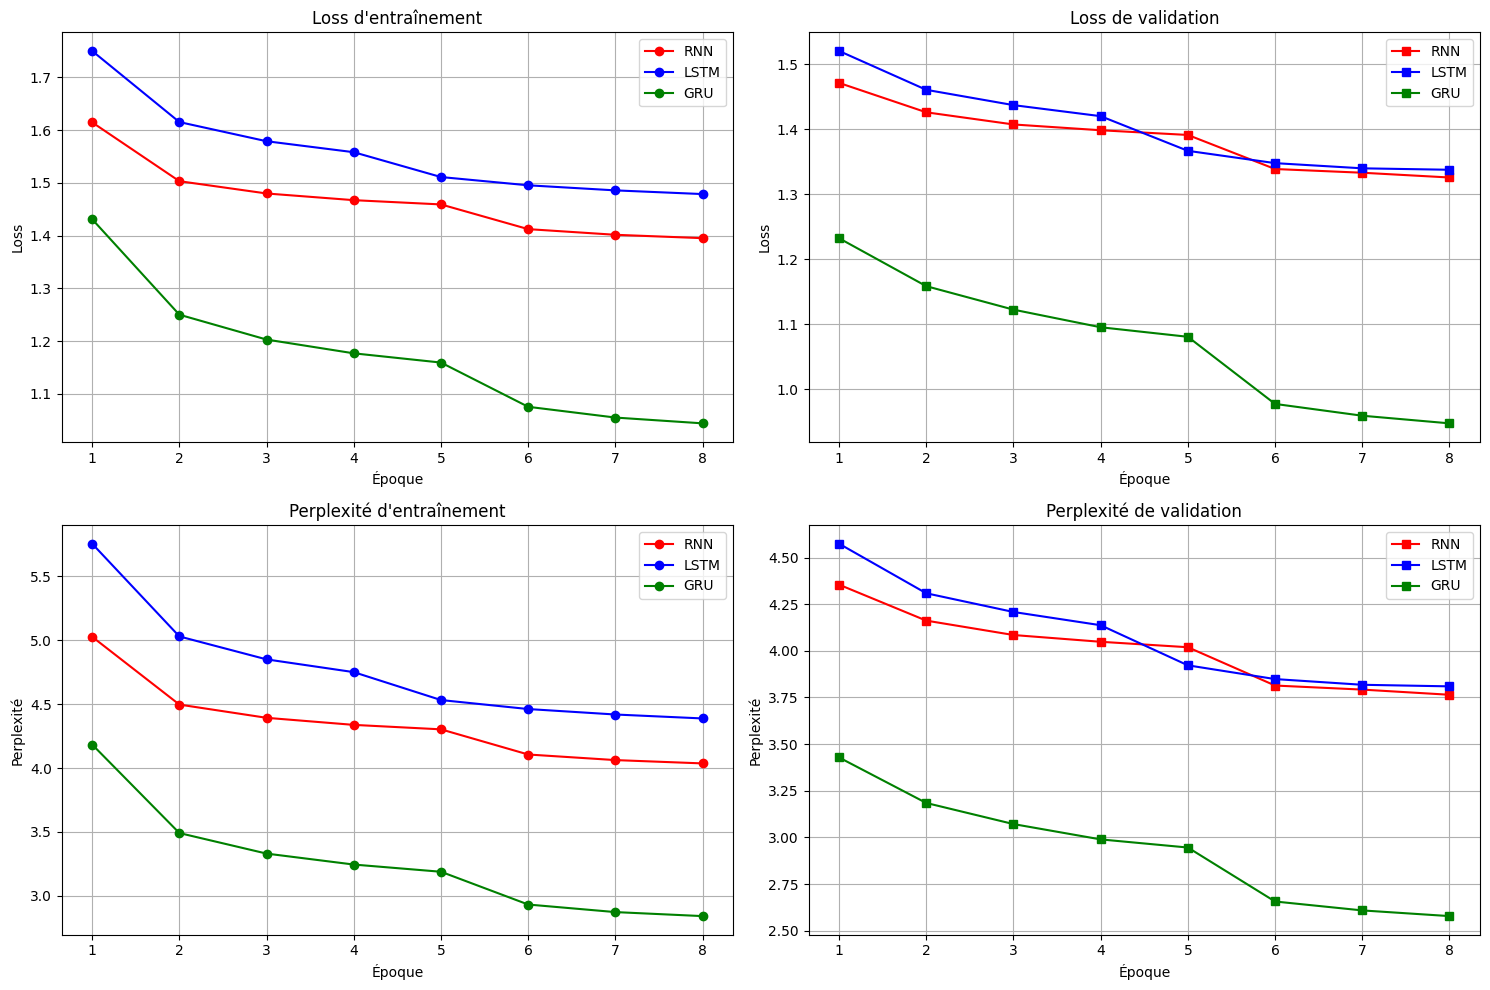


Résumé des performances finales:
RNN:
  - Loss finale (train/val): 1.3953 / 1.3256
  - Perplexité finale (train/val): 4.04 / 3.76

LSTM:
  - Loss finale (train/val): 1.4788 / 1.3375
  - Perplexité finale (train/val): 4.39 / 3.81

GRU:
  - Loss finale (train/val): 1.0443 / 0.9472
  - Perplexité finale (train/val): 2.84 / 2.58



In [69]:
# Visualisation des résultats d'entraînement
def plot_training_results(model_histories):
    """Affiche les courbes de loss et perplexité pour tous les modèles"""
    
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
    
    # Couleurs pour chaque modèle
    colors = {'RNN': 'red', 'LSTM': 'blue', 'GRU': 'green'}
    
    # Loss d'entraînement
    ax1.set_title('Loss d\'entraînement')
    for model_name, history in model_histories.items():
        epochs = range(1, len(history['train_loss']) + 1)
        ax1.plot(epochs, history['train_loss'], 
                color=colors[model_name], label=model_name, marker='o')
    ax1.set_xlabel('Époque')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True)
    
    # Loss de validation
    ax2.set_title('Loss de validation')
    for model_name, history in model_histories.items():
        epochs = range(1, len(history['val_loss']) + 1)
        ax2.plot(epochs, history['val_loss'], 
                color=colors[model_name], label=model_name, marker='s')
    ax2.set_xlabel('Époque')
    ax2.set_ylabel('Loss')
    ax2.legend()
    ax2.grid(True)
    
    # Perplexité d'entraînement
    ax3.set_title('Perplexité d\'entraînement')
    for model_name, history in model_histories.items():
        epochs = range(1, len(history['train_perplexity']) + 1)
        ax3.plot(epochs, history['train_perplexity'], 
                color=colors[model_name], label=model_name, marker='o')
    ax3.set_xlabel('Époque')
    ax3.set_ylabel('Perplexité')
    ax3.legend()
    ax3.grid(True)
    
    # Perplexité de validation
    ax4.set_title('Perplexité de validation')
    for model_name, history in model_histories.items():
        epochs = range(1, len(history['val_perplexity']) + 1)
        ax4.plot(epochs, history['val_perplexity'], 
                color=colors[model_name], label=model_name, marker='s')
    ax4.set_xlabel('Époque')
    ax4.set_ylabel('Perplexité')
    ax4.legend()
    ax4.grid(True)
    
    plt.tight_layout()
    plt.savefig('models/training_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()

# Afficher les résultats si les modèles ont été entraînés
if 'model_histories' in locals() and model_histories:
    print("Visualisation des résultats d'entraînement...")
    plot_training_results(model_histories)
    
    # Résumé des performances finales
    print("\nRésumé des performances finales:")
    print("=" * 50)
    for model_name, history in model_histories.items():
        final_train_loss = history['train_loss'][-1]
        final_val_loss = history['val_loss'][-1]
        final_train_ppl = history['train_perplexity'][-1]
        final_val_ppl = history['val_perplexity'][-1]
        
        print(f"{model_name}:")
        print(f"  - Loss finale (train/val): {final_train_loss:.4f} / {final_val_loss:.4f}")
        print(f"  - Perplexité finale (train/val): {final_train_ppl:.2f} / {final_val_ppl:.2f}")
        print()
else:
    print("Exécutez d'abord la cellule d'entraînement pour voir les résultats.")

In [70]:
# Test de génération avec différents modèles et paramètres (version anglaise)
def test_text_generation():
    """Teste la génération de texte avec tous les modèles"""
    
    # Différents seeds pour tester (en anglais)
    seed_texts = [
        "The ",
        "In the ",
        "I walked ",
        "Love is ",
        "When the ",
        "Beneath ",
        "Upon a "
    ]
    
    # Différentes températures
    temperatures = [0.5, 0.8, 1.0, 1.2]
    
    print("TESTS DE GÉNÉRATION DE TEXTE (ANGLAIS)")
    print("=" * 60)
    
    for model_name, model in models.items():
        print(f"\n{model_name} - Exemples de génération:")
        print("-" * 40)
        
        # Test avec différents seeds (température fixe)
        print("\n1. Différents débuts (température = 0.8):")
        for seed in seed_texts[:4]:  # Limiter pour l'affichage
            generated = generate_text(model, char_encoder, seed, length=150, temperature=0.8)
            print(f"Seed: '{seed}' -> {generated}")
            print()
        
        # Test avec différentes températures (seed fixe)
        print("\n2. Différentes températures (seed = 'The '):")
        for temp in temperatures:
            generated = generate_text(model, char_encoder, "The ", length=100, temperature=temp)
            print(f"Temp {temp}: {generated}")
            print()
        
        print("\n" + "="*60)

# Comparaison détaillée des modèles (version anglaise)
def compare_models_detailed():
    """Compare les modèles en détail"""
    
    print("COMPARAISON DÉTAILLÉE DES MODÈLES (ANGLAIS)")
    print("=" * 50)
    
    # Utiliser le même seed pour une comparaison équitable
    seed_text = "In the silence of the night, "
    temperature = 0.8
    length = 200
    
    print(f"Seed: '{seed_text}'")
    print(f"Température: {temperature}")
    print(f"Longueur: {length} caractères")
    print("\n" + "-" * 50)
    
    for model_name, model in models.items():
        print(f"\n{model_name}:")
        print("-" * 20)
        generated = generate_text(model, char_encoder, seed_text, length, temperature)
        print(generated)
        print("\n" + "="*50)

# Tests supplémentaires avec différents styles
def test_different_styles():
    """Teste différents styles de poèmes"""
    
    print("TESTS DE DIFFÉRENTS STYLES POÉTIQUES")
    print("=" * 50)
    
    style_seeds = {
        "Romantique": "Love is like a ",
        "Nature": "The forest whispers ",
        "Mélancolique": "In my lonely heart ",
        "Épique": "Once upon a time ",
        "Moderne": "The city lights "
    }
    
    # Utiliser le meilleur modèle (LSTM généralement)
    best_model = models['LSTM']
    
    for style, seed in style_seeds.items():
        print(f"\n--- Style {style} ---")
        print(f"Seed: '{seed}'")
        generated = generate_text(best_model, char_encoder, seed, length=200, temperature=0.9)
        print(generated)
        print("\n" + "-" * 40)

# Exécuter les tests si les modèles sont entraînés
if 'models' in locals():
    print("Lancement des tests de génération...")
    test_text_generation()
    
    print("\n\nComparaison détaillée...")
    compare_models_detailed()
    
    print("\n\nTest de différents styles...")
    test_different_styles()
else:
    print("Entraînez d'abord les modèles pour tester la génération.")

Lancement des tests de génération...
TESTS DE GÉNÉRATION DE TEXTE (ANGLAIS)

RNN - Exemples de génération:
----------------------------------------

1. Différents débuts (température = 0.8):
Seed: 'The ' -> The Press not sow
Hear I the wind of earth did did durl hairs,
                                       Be thy selves to folk
And lines do,
Invide of th

Seed: 'In the ' -> In the rived a torn
That it to a souls from Revert the absence lives with me.

The pryself, sit love's springth
All the round shadow what chawk,
    Par

Seed: 'I walked ' -> I walked the wind,
"Wal of me,
A married!
They dead
More and well,
            And the bride, eyes where heav'nly deep on foolishly be sun?
She rules, he

Seed: 'Love is ' -> Love is shall be my love's precious draw rest upon the rest:
The night be.

Stall, still might;
And Praisd and with dinger leave hath pleasure doth langua


2. Différentes températures (seed = 'The '):
Seed: 'In the ' -> In the rived a torn
That it to a souls from Revert 

In [71]:
# Export ONNX du meilleur modèle
def export_to_onnx(model, model_name, seq_length=50):
    """Exporte un modèle au format ONNX"""
    
    model.eval()
    
    # Créer des exemples d'entrée pour l'export
    dummy_input = torch.randint(0, vocab_size, (1, seq_length)).to(device)
    dummy_hidden = model.init_hidden(1)
    
    # Nom du fichier ONNX
    onnx_path = f'models/{model_name}_text_generator.onnx'
    
    try:
        if isinstance(dummy_hidden, tuple):  # LSTM
            torch.onnx.export(
                model,
                (dummy_input, dummy_hidden),
                onnx_path,
                export_params=True,
                opset_version=11,
                do_constant_folding=True,
                input_names=['input_sequence', 'hidden_h', 'hidden_c'],
                output_names=['output', 'new_hidden_h', 'new_hidden_c'],
                dynamic_axes={
                    'input_sequence': {0: 'batch_size', 1: 'sequence_length'},
                    'hidden_h': {1: 'batch_size'},
                    'hidden_c': {1: 'batch_size'},
                    'output': {0: 'batch_size', 1: 'sequence_length'},
                    'new_hidden_h': {1: 'batch_size'},
                    'new_hidden_c': {1: 'batch_size'}
                }
            )
        else:  # RNN, GRU
            torch.onnx.export(
                model,
                (dummy_input, dummy_hidden),
                onnx_path,
                export_params=True,
                opset_version=11,
                do_constant_folding=True,
                input_names=['input_sequence', 'hidden'],
                output_names=['output', 'new_hidden'],
                dynamic_axes={
                    'input_sequence': {0: 'batch_size', 1: 'sequence_length'},
                    'hidden': {1: 'batch_size'},
                    'output': {0: 'batch_size', 1: 'sequence_length'},
                    'new_hidden': {1: 'batch_size'}
                }
            )
        
        print(f"Modèle {model_name} exporté vers: {onnx_path}")
        
        # Vérifier que le modèle ONNX est valide
        onnx_model = onnx.load(onnx_path)
        onnx.checker.check_model(onnx_model)
        print(f"Modèle ONNX {model_name} vérifié avec succès!")
        
        # Tester avec ONNX Runtime
        ort_session = ort.InferenceSession(onnx_path)
        print(f"ONNX Runtime session créée pour {model_name}")
        
        return onnx_path
        
    except Exception as e:
        print(f"Erreur lors de l'export ONNX pour {model_name}: {e}")
        return None

# Sauvegarder les métadonnées pour l'utilisation web
def save_model_metadata():
    """Sauvegarde les métadonnées nécessaires pour l'utilisation web"""
    
    metadata = {
        'char_to_idx': char_encoder.char_to_idx,
        'idx_to_char': char_encoder.idx_to_char,
        'vocab_size': char_encoder.vocab_size,
        'embed_size': embed_size,
        'hidden_size': hidden_size,
        'seq_length': seq_length,
        'model_info': {}
    }
    
    # Ajouter les informations de performance pour chaque modèle
    if 'model_histories' in locals():
        for model_name, history in model_histories.items():
            metadata['model_info'][model_name] = {
                'final_val_loss': history['val_loss'][-1],
                'final_val_perplexity': history['val_perplexity'][-1],
                'num_layers': models[model_name].num_layers
            }
    
    # Sauvegarder en JSON
    with open('models/model_metadata.json', 'w', encoding='utf-8') as f:
        json.dump(metadata, f, ensure_ascii=False, indent=2)
    
    print("Métadonnées sauvegardées dans models/model_metadata.json")

# Exporter tous les modèles si ils sont entraînés
if 'models' in locals():
    print("Export des modèles au format ONNX...")
    
    exported_models = {}
    for model_name, model in models.items():
        onnx_path = export_to_onnx(model, model_name)
        if onnx_path:
            exported_models[model_name] = onnx_path
    
    print(f"\\nModèles exportés: {list(exported_models.keys())}")
    
    # Sauvegarder les métadonnées
    save_model_metadata()
    
    print("\\nExport ONNX terminé! Les modèles sont prêts pour l'utilisation web.")
else:
    print("Entraînez d'abord les modèles avant de les exporter.")

Export des modèles au format ONNX...
Modèle RNN exporté vers: models/RNN_text_generator.onnx
Modèle ONNX RNN vérifié avec succès!
ONNX Runtime session créée pour RNN
Modèle LSTM exporté vers: models/LSTM_text_generator.onnx
Modèle ONNX LSTM vérifié avec succès!
ONNX Runtime session créée pour LSTM
Modèle GRU exporté vers: models/GRU_text_generator.onnx
Modèle LSTM exporté vers: models/LSTM_text_generator.onnx
Modèle ONNX LSTM vérifié avec succès!
ONNX Runtime session créée pour LSTM
Modèle GRU exporté vers: models/GRU_text_generator.onnx


c:\Users\willi\OneDrive\Bureau\ia_rendu_1\.venv\lib\site-packages\torch\onnx\symbolic_opset9.py:4244: UserWarning: Exporting a model to ONNX with a batch_size other than 1, with a variable length with RNN_TANH can cause an error when running the ONNX model with a different batch size. Make sure to save the model with a batch size of 1, or define the initial states (h0/c0) as inputs of the model. 
  warnings.warn(
c:\Users\willi\OneDrive\Bureau\ia_rendu_1\.venv\lib\site-packages\torch\onnx\symbolic_opset9.py:4244: UserWarning: Exporting a model to ONNX with a batch_size other than 1, with a variable length with LSTM can cause an error when running the ONNX model with a different batch size. Make sure to save the model with a batch size of 1, or define the initial states (h0/c0) as inputs of the model. 
  warnings.warn(
c:\Users\willi\OneDrive\Bureau\ia_rendu_1\.venv\lib\site-packages\torch\onnx\symbolic_opset9.py:4244: UserWarning: Exporting a model to ONNX with a batch_size other than 

Modèle ONNX GRU vérifié avec succès!
ONNX Runtime session créée pour GRU
\nModèles exportés: ['RNN', 'LSTM', 'GRU']
Métadonnées sauvegardées dans models/model_metadata.json
\nExport ONNX terminé! Les modèles sont prêts pour l'utilisation web.
